In [1]:
import umap
import pathlib
import warnings
import pprint
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm
from matplotlib import cm

In [2]:
SEED = 64

In [3]:
# Read Data

df_gbg = pd.read_csv('data/GOT_StatisticsTable_Walk_Traf_220429.csv', index_col=False)
df_sthlm = pd.read_csv('data/STO_StatisticsTable_Walk_Traf_220429.csv', index_col=False)

'''
df_gbg_wed = df_gbg.copy()
df_gbg_thu = df_gbg.copy()
df_gbg_fri = df_gbg.copy()

df_gbg_wed['TOTAL_TOT'] = df_gbg_wed['WED_tot']
df_gbg_thu['TOTAL_TOT'] = df_gbg_thu['THU_tot']
df_gbg_fri['TOTAL_TOT'] = df_gbg_fri['FRI_tot']

df_gbg = pd.concat((df_gbg_wed, df_gbg_thu, df_gbg_fri))
'''

# Basic Processing
df_gbg['Area'] = 1 + df_sthlm['Area'].max()
df_gbg['label'] = 'GBG'
df_gbg['TOTAL_TOT'] = df_gbg['WED_tot']
df_gbg['TranspLanes'] = df_gbg['TranspLane']

df_sthlm['FIN_FlowID'] = -1

central_areas = [9, 10, 11, 12, 13, 14]
df_sthlm['label'] = 'STHLM (REST)'
df_sthlm.loc[df_sthlm['Area'].isin(central_areas), 'label'] = 'STHLM (' + df_sthlm.loc[df_sthlm['Area'].isin(central_areas), 'Area'].astype(str) + ')'

# Clean
df_gbg = df_gbg[~df_gbg['FIN_FlowID'].isin([1012])]

# Transform
cat_features = [
    'DenType',
    'CenType',
    'FunkKlass',
    'VagTypNo',
]

cont_features = [
    'FSI_500',
    'GSI_500',
    'Plot_500',
    'LMarkets_500',
    'LMarkets_Str',
    'PubTr_500',
    'PubTr_Str',
    #'Pop_500',
    'WPop_500',
    'NPop_500',
    'SegLength',
    'SidewWidth',
    'CarLanes',
    'TranspLanes',
    'TotLanes',
    'SpeedLim',
    'Int500',
    'Int1000',
    'Int2000',
    'Bet500',
    'Bet1000',
    'Bet2000',
    'ATd_500',
    'ATd_2000',
    'ATm_500',
    'ATm_2000',
]

df = pd.concat((
    df_gbg[['label', 'Area', 'FIN_FlowID', 'TOTAL_TOT'] + cat_features + cont_features],
    df_sthlm[['label', 'Area', 'FIN_FlowID', 'TOTAL_TOT'] + cat_features + cont_features]
), axis=0)

transform_features = [
    'LMarkets_Str',
    'PubTr_500',
    'PubTr_Str',
    'WPop_500',
    'NPop_500',
    'SidewWidth',
    'Int500',
    'Int1000',
    'Int2000',
    'Bet500',
    'Bet1000',
    'Bet2000',
    'ATd_500',
    'ATd_2000',
    'ATm_500',
    'ATm_2000'
]

df[transform_features] = np.log1p(df[transform_features])

df_tmp = df.copy()
df_dummy = pd.get_dummies(df[cat_features], columns=cat_features)
print(df_dummy.columns)
dummy_features = list(df_dummy.columns)
df = pd.concat((df, df_dummy), axis=1)


# Save
feature_names = dummy_features + cont_features
df = df[['label', 'Area', 'FIN_FlowID', 'TOTAL_TOT'] + feature_names]
target_feature = 'TOTAL_TOT'

df.to_csv('data/df_comb_scaled.csv', index=False)

print(df.shape)
display(df)


Index(['DenType_1', 'DenType_2', 'DenType_3', 'DenType_5', 'DenType_6',
       'CenType_1', 'CenType_2', 'CenType_3', 'CenType_4', 'FunkKlass_4',
       'FunkKlass_5', 'FunkKlass_6', 'FunkKlass_7', 'FunkKlass_8',
       'FunkKlass_9', 'VagTypNo_1', 'VagTypNo_2', 'VagTypNo_3', 'VagTypNo_4',
       'VagTypNo_5'],
      dtype='object')
(299, 49)


,label,Area,FIN_FlowID,TOTAL_TOT,DenType_1,DenType_2,DenType_3,DenType_5,DenType_6,CenType_1,...,Int500,Int1000,Int2000,Bet500,Bet1000,Bet2000,ATd_500,ATd_2000,ATm_500,ATm_2000
0,GBG,18,41,4912.0,0,0,1,0,0,0,...,4.853301,5.514806,6.712068,8.920255,10.544405,12.746322,20.180398,25.453698,3.245193,8.059382
1,GBG,18,9045,4306.0,0,0,1,0,0,1,...,4.943803,6.200354,7.027163,7.316797,9.916642,11.339828,22.129607,25.468407,7.480381,9.548959
2,GBG,18,20045,2182.0,0,0,1,0,0,1,...,4.816964,5.975469,6.834467,7.336164,9.525566,10.705858,21.447573,24.860619,6.233430,8.793555
3,GBG,18,47,6427.0,0,0,1,0,0,0,...,4.844013,5.943115,6.743375,9.495557,11.458505,13.234309,21.939808,26.203627,3.597312,8.819591
4,GBG,18,35042,5653.0,0,0,1,0,0,0,...,5.060012,6.043233,6.917658,9.079322,11.580824,13.099639,23.497466,26.806884,8.206913,10.457752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,STHLM (14),14,-1,217.0,0,0,1,0,0,1,...,4.665192,5.785657,6.535744,6.980076,9.222022,10.518092,23.940019,25.740070,7.381191,8.822027
220,STHLM (13),13,-1,883.0,0,0,0,1,0,1,...,4.556201,5.432465,6.310346,7.515072,9.412955,10.713840,23.062391,25.604985,4.762174,6.869014
221,STHLM (14),14,-1,70.0,0,0,1,0,0,1,...,4.495310,5.862270,6.580397,5.605802,8.786991,11.592374,23.587587,27.045339,6.936829,9.463101
222,STHLM (14),14,-1,120.0,0,0,1,0,0,1,...,4.618243,5.804070,6.534835,6.825189,9.210965,10.498064,23.919717,25.731302,7.433519,8.759472


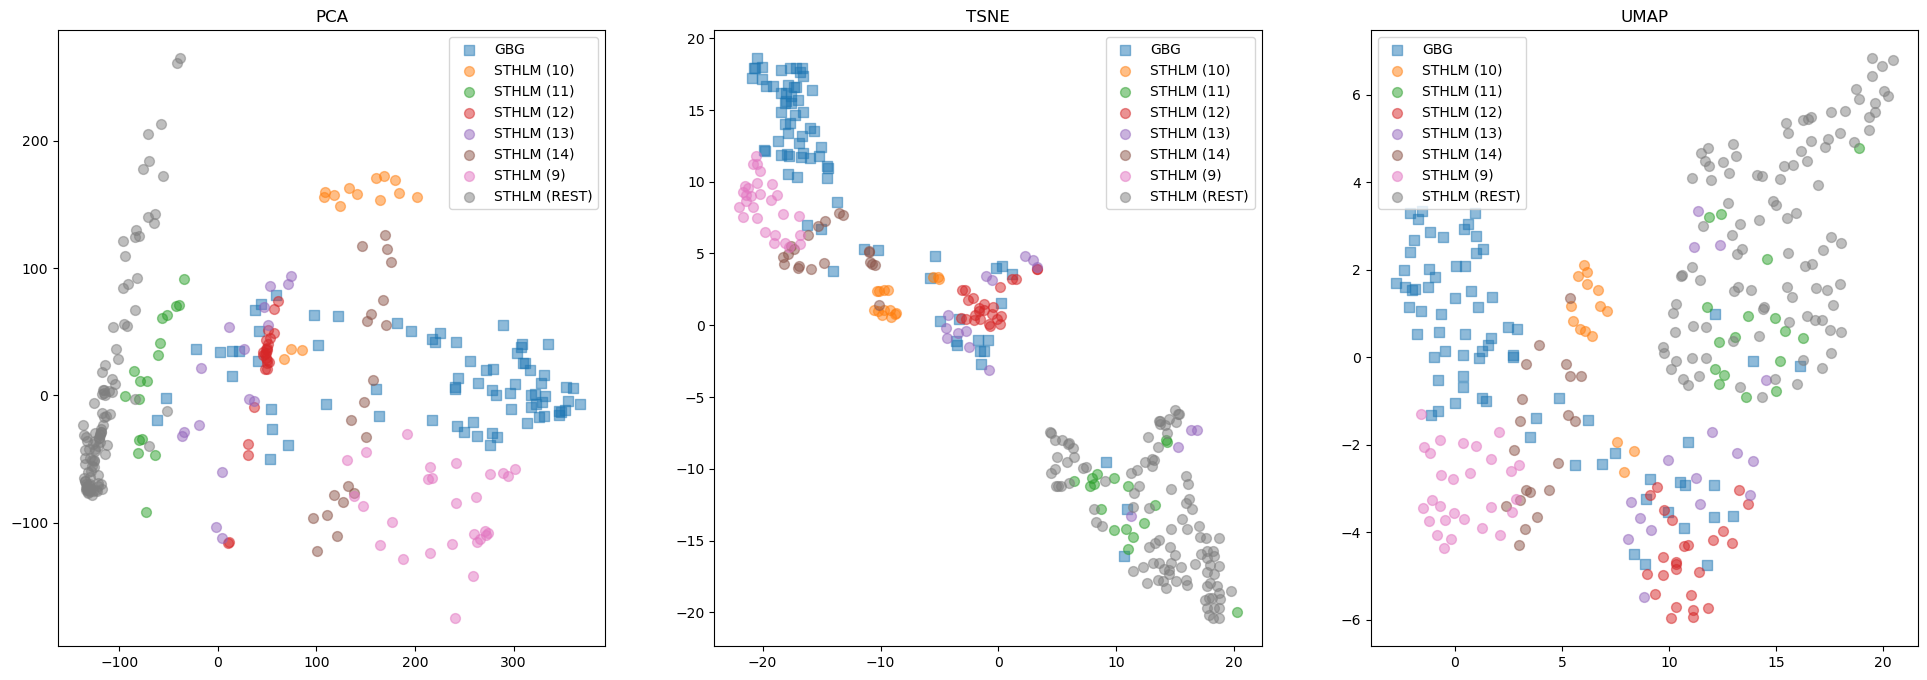

In [4]:
# PLotting

pca = PCA(n_components=2)
umap_ = umap.UMAP(n_components=2, n_neighbors=15, min_dist=1.0, random_state=SEED)
tsne = TSNE(n_components=2, random_state=SEED)
scaler = ColumnTransformer(
    [
        ('scaler', StandardScaler(), cont_features)
    ],
    remainder='passthrough'
)

gbg_ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].copy()
X_gbg = df.loc[df['label'] == 'GBG', feature_names].copy()
labels_gbg = df.loc[df['label'] == 'GBG', 'label'].values
X_sthlm = df.loc[df['label'] != 'GBG', feature_names].copy()
labels_sthlm = df.loc[df['label'] != 'GBG', 'label'].values

pca_sthlm = pca.fit_transform(X_sthlm)
pca_gbg = pca.transform(X_gbg)

X = np.concatenate((X_gbg, X_sthlm), axis=0)
labels = np.concatenate((labels_gbg, labels_sthlm))

umap_feat = umap_.fit_transform(X)
tsne_feat = tsne.fit_transform(X)

fig, ax = plt.subplots(1, 3, figsize=(24,8))

ax[0].scatter(pca_gbg[:, 0], pca_gbg[:, 1], label='GBG', s=50, alpha=0.5, marker='s')
ax[1].scatter(tsne_feat[labels == 'GBG', 0], tsne_feat[labels == 'GBG', 1], label='GBG', s=50, alpha=0.5, marker='s')
ax[2].scatter(umap_feat[labels == 'GBG', 0], umap_feat[labels == 'GBG', 1], label='GBG', s=50, alpha=0.5, marker='s')

for l in np.unique(labels_sthlm):
    
    ax[0].scatter(pca_sthlm[labels_sthlm == l, 0], pca_sthlm[labels_sthlm == l, 1], label=l, s=50, alpha=0.5)
    ax[1].scatter(tsne_feat[labels == l, 0], tsne_feat[labels == l, 1], label=l, s=50, alpha=0.5)
    ax[2].scatter(umap_feat[labels == l, 0], umap_feat[labels == l, 1], label=l, s=50, alpha=0.5)

ax[0].legend()
ax[0].set_title('PCA')
ax[1].legend()
ax[1].set_title('TSNE')     
ax[2].legend()
ax[2].set_title('UMAP')
        
plt.show()


In [5]:
# GBG->GBG

n_removals = 50

df_test = pd.DataFrame()

ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
y = df.loc[df['label'] == 'GBG', target_feature].values
row = {ids[i]: y[i] for i in range(ids.shape[0])}
row['method'] = 'True'

df_test = df_test.append(row, ignore_index=True)

pipe = Pipeline(
    [

        ('model', TransformedTargetRegressor(
                regressor=Lasso(
                    fit_intercept=True,
                    positive=False,
                    random_state=SEED
                ),
                func=np.log,
                inverse_func=np.exp
        ))
    ]
)

params = {
    'model__regressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
}

# GBG (Train)
print('GBG (Train Only)')
X = df.loc[df['label'] == 'GBG', feature_names].reset_index(drop=True)
y = df.loc[df['label'] == 'GBG', target_feature].reset_index(drop=True)

cv = LeaveOneOut()
gs = GridSearchCV(
    pipe,
    param_grid=params,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
    refit=True,
)
gs.fit(X, y)
gbg_only_intercept = gs.best_estimator_['model'].regressor_.intercept_
gbg_only_coefs = gs.best_estimator_['model'].regressor_.coef_
y_pred = gs.predict(X)
    
ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
row = {ids[i]: y_pred[i] for i in range(ids.shape[0])}
row['method'] = 'GBG (Train Only)'
df_test = df_test.append(row, ignore_index=True)

# GBG (LOO Nested)
print('GBG (LOO Nested)')
X = df.loc[df['label'] == 'GBG', feature_names].reset_index(drop=True)
y = df.loc[df['label'] == 'GBG', target_feature].reset_index(drop=True)

y_pred = []
fold_nr = 1
gbg_loo_intercepts = []
gbg_loo_coefs = []
for train_index, test_index in LeaveOneOut().split(X):
    
    #print(fold_nr)
    fold_nr += 1
    
    cv = LeaveOneOut()
    gs = GridSearchCV(
        pipe,
        param_grid=params,
        cv=cv,
        scoring='neg_mean_absolute_percentage_error',
        refit=True,
    )
    
    gs.fit(X.loc[train_index, :], y.loc[train_index])
    gbg_loo_intercepts.append(gs.best_estimator_['model'].regressor_.intercept_)
    gbg_loo_coefs.append(gs.best_estimator_['model'].regressor_.coef_)
    #print(gs.best_estimator_)
    #print(gs.best_estimator_['model'].regressor_.intercept_)
    #print(gs.best_estimator_['model'].regressor_.coef_)
    
    y_pred.extend(gs.predict(X.loc[test_index, :]))
    
gbg_loo_intercepts = np.array(gbg_loo_intercepts)
gbg_loo_coefs = np.array(gbg_loo_coefs)
    
ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
row = {ids[i]: y_pred[i] for i in range(ids.shape[0])}
row['method'] = 'GBG (LOO Nested)'
df_test = df_test.append(row, ignore_index=True)

# GBG (10-Fold Nested)
print('GBG (10-Fold Nested)')
X = df.loc[df['label'] == 'GBG', feature_names].reset_index(drop=True)
y = df.loc[df['label'] == 'GBG', target_feature].reset_index(drop=True)

y_pred = []
fold_nr = 1
gbg_10fold_intercepts = []
gbg_10fold_coefs = []
for train_index, test_index in KFold(n_splits=10, shuffle=True, random_state=SEED).split(X):
    
    #print(fold_nr)
    fold_nr += 1
    
    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    gs = GridSearchCV(
        pipe,
        param_grid=params,
        cv=cv,
        scoring='neg_mean_absolute_percentage_error',
        return_train_score=True,
        refit=True,
    )
    
    gs.fit(X.loc[train_index, :], y.loc[train_index])
    gbg_10fold_intercepts.append(gs.best_estimator_['model'].regressor_.intercept_)
    gbg_10fold_coefs.append(gs.best_estimator_['model'].regressor_.coef_)
    #print(gs.best_estimator_)
    #print(gs.best_estimator_['model'].regressor_.intercept_)
    #print(gs.best_estimator_['model'].regressor_.coef_)
    
    y_pred.extend(gs.predict(X.loc[test_index, :]))
    
gbg_10fold_intercepts = np.array(gbg_10fold_intercepts)
gbg_10fold_coefs = np.array(gbg_10fold_coefs)
    
ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
row = {ids[i]: y_pred[i] for i in range(ids.shape[0])}
row['method'] = 'GBG (10-Fold Nested)'
df_test = df_test.append(row, ignore_index=True)


GBG (Train Only)
GBG (LOO Nested)
GBG (10-Fold Nested)


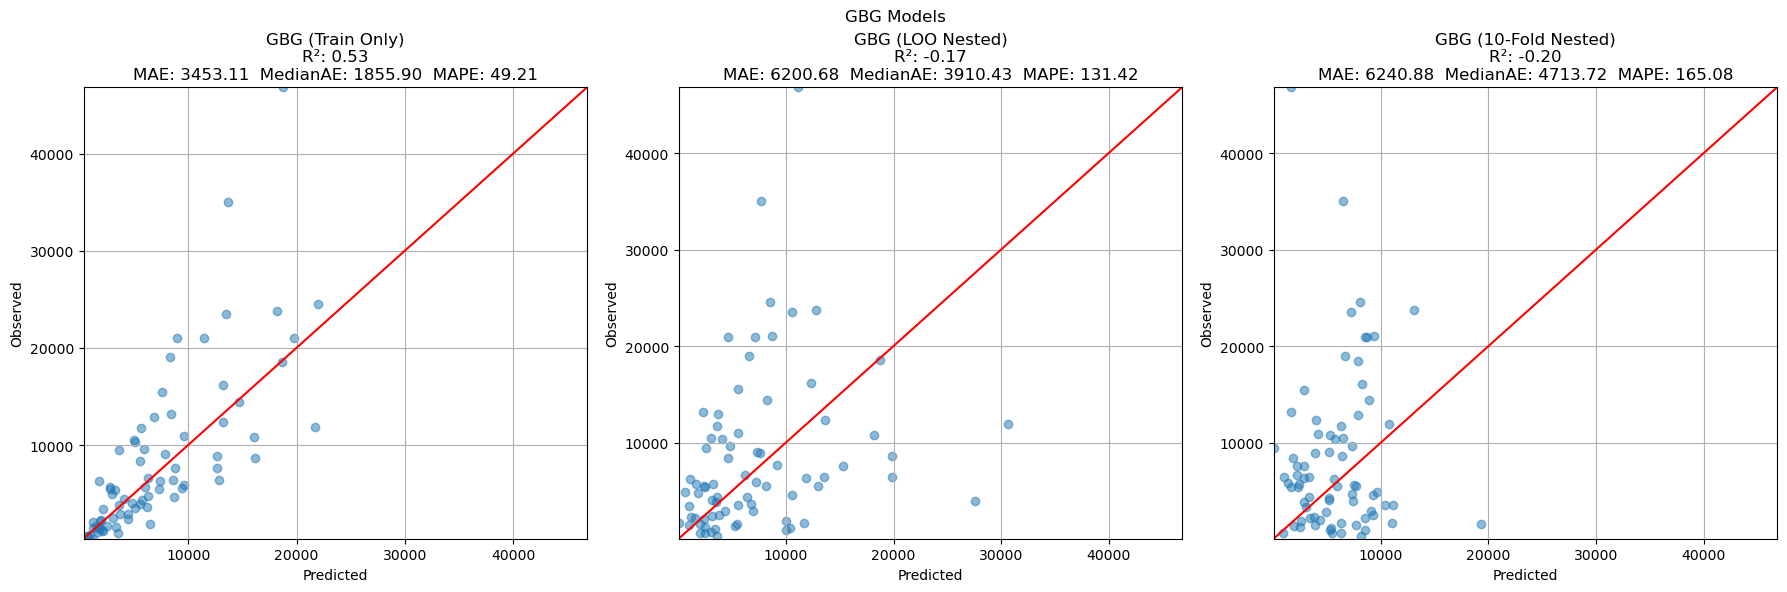

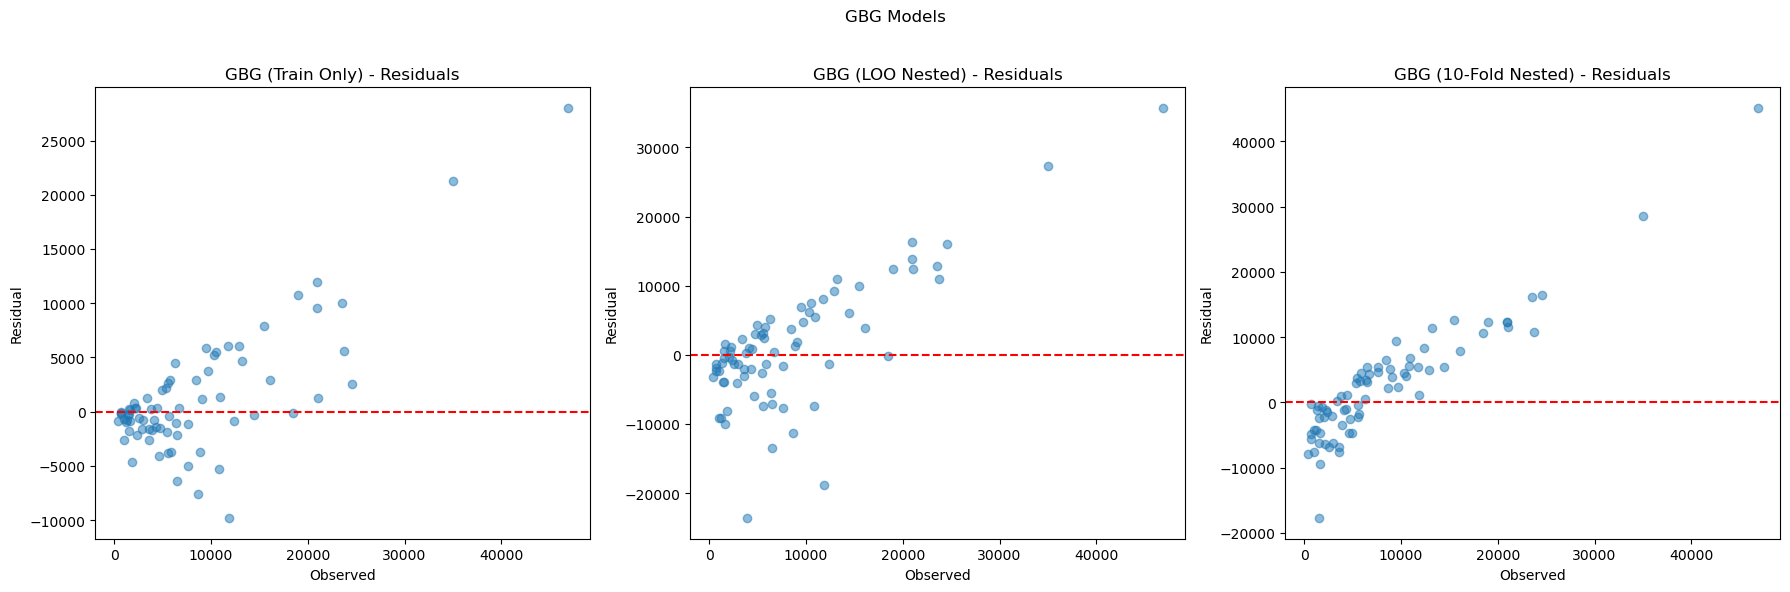

In [6]:
# Plot Performance

offset = 5000

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

y_true = df_test.loc[df_test['method'] == 'True', df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

key = 'GBG (Train Only)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

_min = min(min(y_true), min(y_pred))
_max = max(max(y_true), max(y_pred))

ax[0].scatter(y_pred, y_true, alpha=0.5)
ax[0].set_ylabel('Observed')
ax[0].set_xlabel('Predicted')
r2 = '\nR²: ' + '{0:.2f}'.format(r2_score(y_true, y_pred))
mae = '\nMAE: '+ '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)) + '  MedianAE: '+ '{0:.2f}'.format(median_absolute_error(y_true, y_pred))
ax[0].set_title(key + r2 + '\nMAE: '+ '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)) + '  MedianAE: '+ '{0:.2f}'.format(median_absolute_error(y_true, y_pred)) + '  MAPE: '+ '{0:.2f}'.format(np.mean(np.abs((y_true - y_pred) / y_true)) * 100))
ax[0].set_xlim(_min, _max)
ax[0].set_ylim(_min, _max)
ax[0].plot([_min, _max], [_min, _max], color='r')
ax[0].grid(True)

key = 'GBG (LOO Nested)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

_min = min(min(y_true), min(y_pred))
_max = max(max(y_true), max(y_pred))

ax[1].scatter(y_pred, y_true, alpha=0.5)
ax[1].set_ylabel('Observed')
ax[1].set_xlabel('Predicted')
r2 = '\nR²: ' + '{0:.2f}'.format(r2_score(y_true, y_pred))
mae = '\nMAE: '+ '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)) + '  MedianAE: '+ '{0:.2f}'.format(median_absolute_error(y_true, y_pred))
ax[1].set_title(key + r2 + '\nMAE: '+ '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)) + '  MedianAE: '+ '{0:.2f}'.format(median_absolute_error(y_true, y_pred)) + '  MAPE: '+ '{0:.2f}'.format(np.mean(np.abs((y_true - y_pred) / y_true)) * 100))
ax[1].set_xlim(_min, _max)
ax[1].set_ylim(_min, _max)
ax[1].plot([_min, _max], [_min, _max], color='r')
ax[1].grid(True)

key = 'GBG (10-Fold Nested)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

_min = min(min(y_true), min(y_pred))
_max = max(max(y_true), max(y_pred))

ax[2].scatter(y_pred, y_true, alpha=0.5)
ax[2].set_ylabel('Observed')
ax[2].set_xlabel('Predicted')
r2 = '\nR²: ' + '{0:.2f}'.format(r2_score(y_true, y_pred))
mae = '\nMAE: '+ '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)) + '  MedianAE: '+ '{0:.2f}'.format(median_absolute_error(y_true, y_pred))
ax[2].set_title(key + r2 + '\nMAE: '+ '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)) + '  MedianAE: '+ '{0:.2f}'.format(median_absolute_error(y_true, y_pred)) + '  MAPE: '+ '{0:.2f}'.format(np.mean(np.abs((y_true - y_pred) / y_true)) * 100))
ax[2].set_xlim(_min, _max)
ax[2].set_ylim(_min, _max)
ax[2].plot([_min, _max], [_min, _max], color='r')
ax[2].grid(True)

plt.suptitle('GBG Models')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

############################################

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

y_true = df_test.loc[df_test['method'] == 'True', df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()
_min  = df_test[df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].min().min() - offset
_max  = df_test[df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].max().max() + offset

key = 'GBG (Train Only)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

ax[0].scatter(y_true, y_true-y_pred, alpha=0.5)
ax[0].set_ylabel('Residual')
ax[0].set_xlabel('Observed')
ax[0].set_title(key + ' - Residuals')
ax[0].axhline(y=0, color='r', linestyle='--')

key = 'GBG (LOO Nested)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

ax[1].scatter(y_true, y_true-y_pred, alpha=0.5)
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('Observed')
ax[1].set_title(key + ' - Residuals')
ax[1].axhline(y=0, color='r', linestyle='--')

key = 'GBG (10-Fold Nested)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

ax[2].scatter(y_true, y_true-y_pred, alpha=0.5)
ax[2].set_ylabel('Residual')
ax[2].set_xlabel('Observed')
ax[2].set_title(key + ' - Residuals')
ax[2].axhline(y=0, color='r', linestyle='--')

plt.suptitle('GBG Models')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()



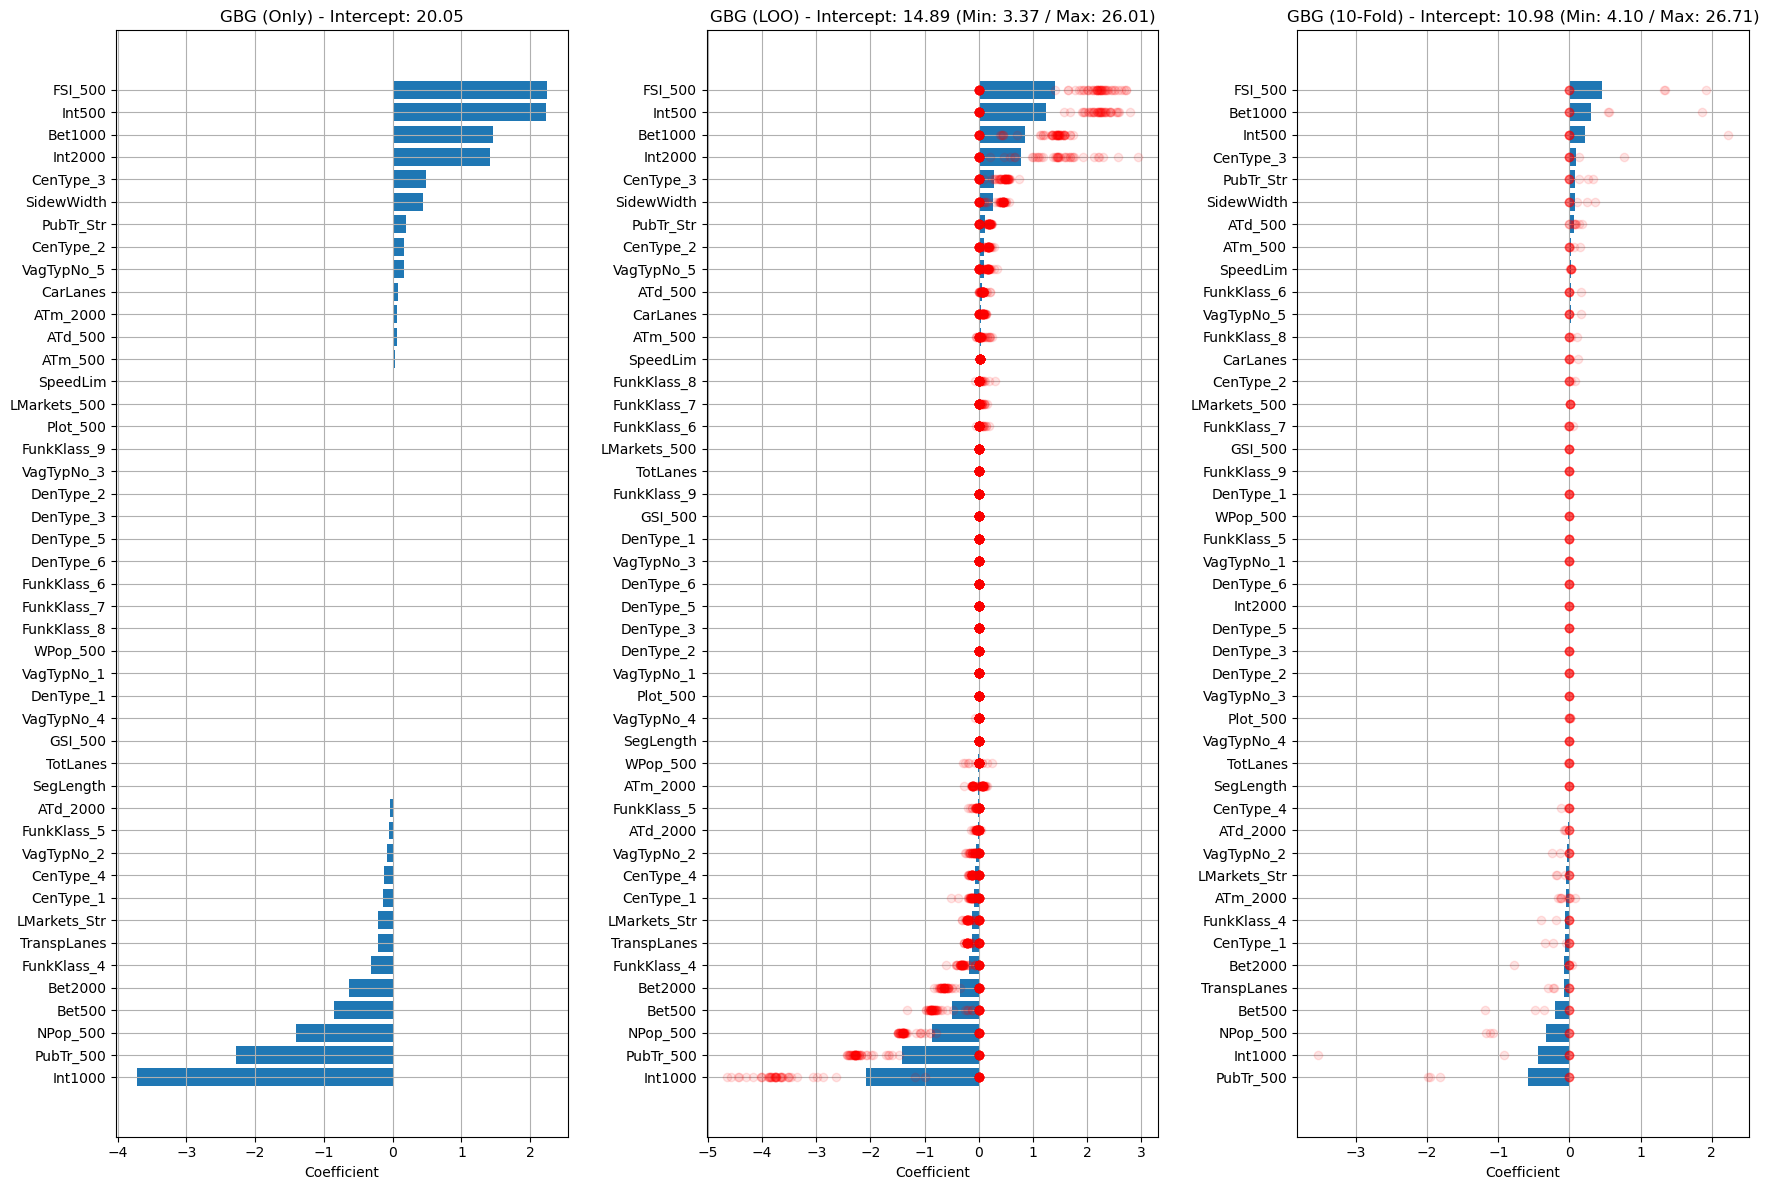

In [7]:
# Plot Coefficients

fix, ax = plt.subplots(1, 3, figsize=(18,12))

f = np.array(feature_names)
idx = np.argsort(gbg_only_coefs)[::-1]
x = np.arange(idx.shape[0])

ax[0].barh(x, gbg_only_coefs[idx], align='center')
ax[0].set_yticks(x)
ax[0].set_yticklabels(f[idx])
ax[0].invert_yaxis()
ax[0].grid(True)
ax[0].set_title('GBG (Only) - Intercept: ' + '{:.2f}'.format(gbg_only_intercept))
ax[0].set_xlabel('Coefficient')

f = np.array(feature_names)
idx = np.argsort(gbg_loo_coefs.mean(axis=0))[::-1]
x = np.arange(idx.shape[0])

ax[1].barh(x, gbg_loo_coefs.mean(axis=0)[idx], align='center', zorder=0)

for i in range(gbg_loo_coefs.shape[0]):
    ax[1].scatter(gbg_loo_coefs[i, idx], x, c='red', alpha=0.1, zorder=10)

ax[1].set_yticks(x)
ax[1].set_yticklabels(f[idx])
ax[1].invert_yaxis()
ax[1].grid(True)
ax[1].set_title('GBG (LOO) - Intercept: ' + '{:.2f}'.format(gbg_loo_intercepts.mean(axis=0)) + ' (Min: ' + '{:.2f}'.format(gbg_loo_intercepts.min(axis=0)) + ' / Max: ' + '{:.2f}'.format(gbg_loo_intercepts.max(axis=0)) + ')')
ax[1].set_xlabel('Coefficient')

f = np.array(feature_names)
idx = np.argsort(gbg_10fold_coefs.mean(axis=0))[::-1]
x = np.arange(idx.shape[0])

ax[2].barh(x, gbg_10fold_coefs.mean(axis=0)[idx], align='center', zorder=0)

for i in range(gbg_10fold_coefs.shape[0]):
    ax[2].scatter(gbg_10fold_coefs[i, idx], x, c='red', alpha=0.1, zorder=10)

ax[2].set_yticks(x)
ax[2].set_yticklabels(f[idx])
ax[2].invert_yaxis()
ax[2].grid(True)
ax[2].set_title('GBG (10-Fold) - Intercept: ' + '{:.2f}'.format(gbg_10fold_intercepts.mean(axis=0)) + ' (Min: ' + '{:.2f}'.format(gbg_10fold_intercepts.min(axis=0)) + ' / Max: ' + '{:.2f}'.format(gbg_10fold_intercepts.max(axis=0)) + ')')
ax[2].set_xlabel('Coefficient')

plt.tight_layout()
plt.show()


In [8]:
# STHLM Default Models
# STHLM->GBG (Central), STHLM->GBG (All)

n_removals = 50

df_test = pd.DataFrame()

ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
y = df.loc[df['label'] == 'GBG', target_feature].values
row = {ids[i]: y[i] for i in range(ids.shape[0])}
row['method'] = 'True'

df_test = df_test.append(row, ignore_index=True)

pipe = Pipeline(
    [
        #('transform', ColumnTransformer(transformers=[('scaler', StandardScaler(), cont_features)], remainder='passthrough')),
        ('model', TransformedTargetRegressor(
                regressor=Lasso(
                    fit_intercept=True,
                    positive=False,
                    random_state=SEED
                ),
                func=np.log,
                inverse_func=np.exp
        ))
    ]
)

params = {
    'model__regressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
}

intercept_model = Pipeline(
    [
        ('model', TransformedTargetRegressor(
                regressor=LinearRegression(
                    fit_intercept=False,
                ),
                func=np.log,
                inverse_func=np.exp
        ))
    ]
)

# STHLM (Central)
print('STHLM (Central)')

central_areas = [9, 10, 11, 12, 13, 14]
areas_sthlm = df.loc[(df['label'] != 'GBG') & (df['Area'].isin(central_areas)), 'Area'].values
X_sthlm = df.loc[(df['label'] != 'GBG') & (df['Area'].isin(central_areas)), feature_names]
y_sthlm = df.loc[(df['label'] != 'GBG') & (df['Area'].isin(central_areas)), target_feature]
print(X_sthlm.shape)

X_gbg = df.loc[df['label'] == 'GBG', feature_names]
print(X_gbg.shape)

intercept_model.fit(pd.DataFrame({'intercept': [1 for i in range(X_sthlm.shape[0])]}), y_sthlm)
intercept_predict = intercept_model.predict(pd.DataFrame({'intercept': [1 for i in range(X_gbg.shape[0])]}))
ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
row = {ids[i]: intercept_predict[i] for i in range(ids.shape[0])}
row['method'] = 'STHLM (Central) - Intercept'
df_test = df_test.append(row, ignore_index=True)

cv = LeaveOneGroupOut().split(X_sthlm, y_sthlm, areas_sthlm)
gs = GridSearchCV(
    pipe,
    param_grid=params,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
    refit=True,
)
gs.fit(X_sthlm, y_sthlm, groups=areas_sthlm)
d = pd.DataFrame(gs.cv_results_)
print('Train Score', d.iloc[gs.best_index_]['mean_train_score'])
print('Val Score', d.iloc[gs.best_index_]['mean_test_score'])
pprint.pprint(gs.best_params_)
central_intercept = gs.best_estimator_['model'].regressor_.intercept_
central_coefs = gs.best_estimator_['model'].regressor_.coef_
y_pred = gs.predict(X_gbg)

ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
row = {ids[i]: y_pred[i] for i in range(ids.shape[0])}
row['method'] = 'STHLM (Central)'
df_test = df_test.append(row, ignore_index=True)

central_removal_r2s = []
central_removal_maes = []

y_true = df.loc[df['label'] == 'GBG', target_feature].values
X_gbg = df.loc[df['label'] == 'GBG', feature_names].reset_index(drop=True)

for i in range(n_removals):
    
    y_pred = gs.predict(X_gbg)
    
    central_removal_r2s.append(r2_score(y_true, y_pred))
    central_removal_maes.append(mean_absolute_error(y_true, y_pred))
    
    idx = np.argmax(y_true)
    y_true = np.delete(y_true, idx)
    X_gbg = X_gbg.drop(idx, axis=0).reset_index(drop=True)
    

# STHLM (All)
print('STHLM (All)')

areas_sthlm = df.loc[df['label'] != 'GBG', 'Area'].values
X_sthlm = df.loc[df['label'] != 'GBG', feature_names]
y_sthlm = df.loc[df['label'] != 'GBG', target_feature]
print(X_sthlm.shape)

X_gbg = df.loc[df['label'] == 'GBG', feature_names]
print(X_gbg.shape)

intercept_model.fit(pd.DataFrame({'intercept': [1 for i in range(X_sthlm.shape[0])]}), y_sthlm)
intercept_predict = intercept_model.predict(pd.DataFrame({'intercept': [1 for i in range(X_gbg.shape[0])]}))
ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
row = {ids[i]: intercept_predict[i] for i in range(ids.shape[0])}
row['method'] = 'STHLM (All) - Intercept'
df_test = df_test.append(row, ignore_index=True)

cv = LeaveOneGroupOut()#.split(X_sthlm, y_sthlm, areas_sthlm)
gs = GridSearchCV(
    pipe,
    param_grid=params,
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True,
    refit=True,
)
gs.fit(X_sthlm, y_sthlm, groups=areas_sthlm)
d = pd.DataFrame(gs.cv_results_)
print('Train Score', d.iloc[gs.best_index_]['mean_train_score'])
print('Val Score', d.iloc[gs.best_index_]['mean_test_score'])
pprint.pprint(gs.best_params_)
all_intercept = gs.best_estimator_['model'].regressor_.intercept_
all_coefs = gs.best_estimator_['model'].regressor_.coef_
y_pred = gs.predict(X_gbg)

ids = df.loc[df['label'] == 'GBG', 'FIN_FlowID'].values
row = {ids[i]: y_pred[i] for i in range(ids.shape[0])}
row['method'] = 'STHLM (All)'
df_test = df_test.append(row, ignore_index=True)

all_removal_r2s = []
all_removal_maes = []

y_true = df.loc[df['label'] == 'GBG', target_feature].values
X_gbg = df.loc[df['label'] == 'GBG', feature_names].reset_index(drop=True)

for i in range(n_removals):
    
    y_pred = gs.predict(X_gbg)
    
    all_removal_r2s.append(r2_score(y_true, y_pred))
    all_removal_maes.append(mean_absolute_error(y_true, y_pred))
    
    idx = np.argmax(y_true)
    y_true = np.delete(y_true, idx)
    X_gbg = X_gbg.drop(idx, axis=0).reset_index(drop=True)

STHLM (Central)
(121, 45)
(75, 45)
Train Score -1.027491533061974
Val Score -1.2913628965969302
{'model__regressor__alpha': 0.5}
STHLM (All)
(224, 45)
(75, 45)
Train Score -1.190145824806608
Val Score -1.4548039630682275
{'model__regressor__alpha': 0.1}


In [9]:
# Save Predictions
df_tmp = pd.DataFrame({
    'FIN_FlowID': df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist(),
    'y_true': df_test.loc[df_test['method'] == 'True', df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten(),
    'STHLM_central_y_pred': df_test.loc[df_test['method'] == 'STHLM (Central)', df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten(),
    'STHLM_all_y_pred': df_test.loc[df_test['method'] == 'STHLM (All)', df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten(),
})

df_tmp.to_csv('data/evaluation.csv', index=False)

STHLM (Central)
MAE: 4889.11
MedAE: 2793.81
MAPE: 100.69
R²: 0.52
STHLM (All)
MAE: 5093.32
MedAE: 3535.59
MAPE: 96.30
R²: 0.50


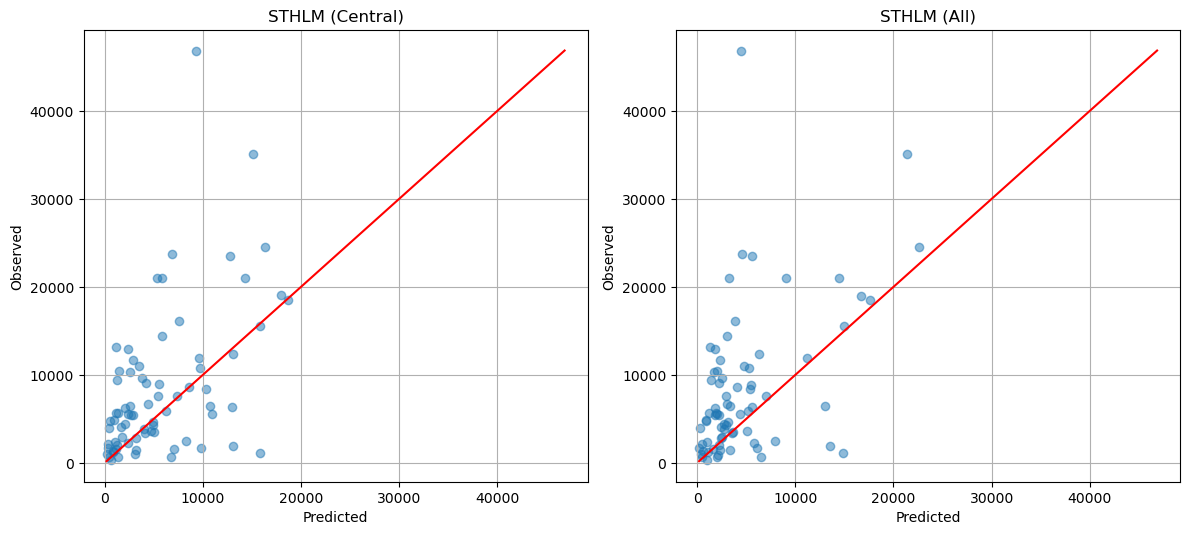

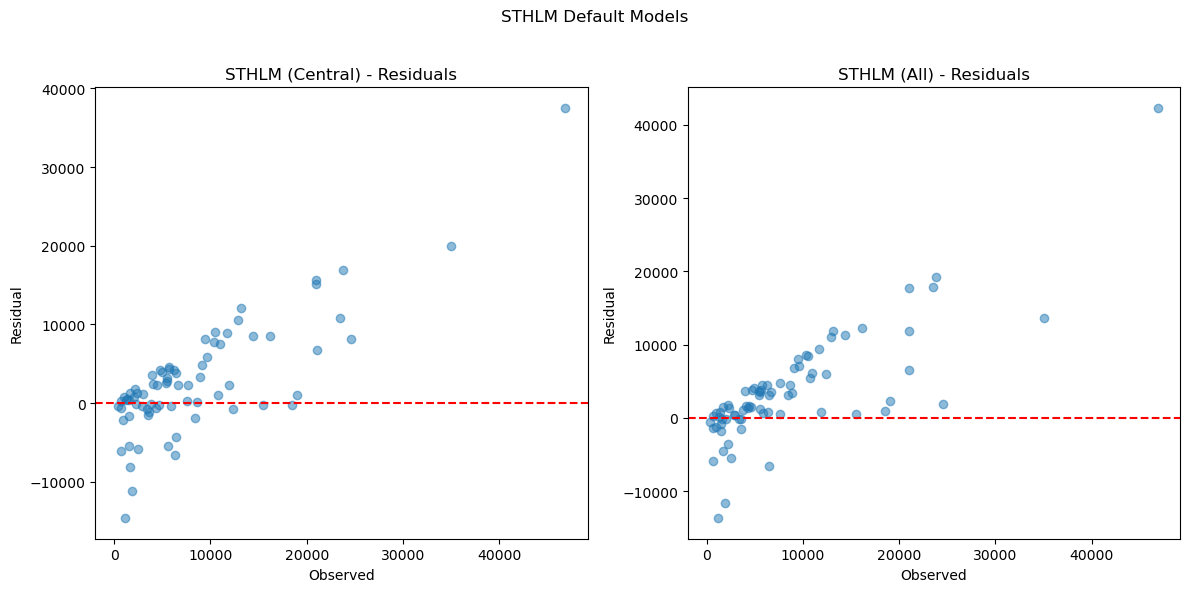

In [10]:
# Plot Performance

offset = 5000

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

y_true = df_test.loc[df_test['method'] == 'True', df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

key = 'STHLM (Central) - Intercept'
intercept_y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

key = 'STHLM (Central)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

_min = min(min(y_true), min(y_pred))
_max = max(max(y_true), max(y_pred))

ax[0].scatter(y_pred, y_true, alpha=0.5)
ax[0].set_ylabel('Observed')
ax[0].set_xlabel('Predicted')

print(key)
print('MAE: ' + '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)))
print('MedAE: ' + '{0:.2f}'.format(median_absolute_error(y_true, y_pred)))
print('MAPE: ' + '{0:.2f}'.format(np.mean(np.abs((y_true - y_pred) / y_true)) * 100))
print('R²: ' + '{0:.2f}'.format(1.0 -  (mean_squared_error(y_true, y_pred)/mean_squared_error(y_true, intercept_y_pred))))

ax[0].set_title(key)
ax[0].set_xlim(_min - 0.05*(_max-_min), _max + 0.05*(_max-_min))
ax[0].set_ylim(_min - 0.05*(_max-_min), _max + 0.05*(_max-_min))
ax[0].plot([_min, _max], [_min, _max], color='r')
ax[0].grid(True)

key = 'STHLM (All) - Intercept'
intercept_y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()
key = 'STHLM (All)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

_min = min(min(y_true), min(y_pred))
_max = max(max(y_true), max(y_pred))

ax[1].scatter(y_pred, y_true, alpha=0.5)
ax[1].set_ylabel('Observed')
ax[1].set_xlabel('Predicted')

print(key)
print('MAE: ' + '{0:.2f}'.format(mean_absolute_error(y_true, y_pred)))
print('MedAE: ' + '{0:.2f}'.format(median_absolute_error(y_true, y_pred)))
print('MAPE: ' + '{0:.2f}'.format(np.mean(np.abs((y_true - y_pred) / y_true)) * 100))
print('R²: ' + '{0:.2f}'.format(1.0 -  (mean_squared_error(y_true, y_pred)/mean_squared_error(y_true, intercept_y_pred))))

ax[1].set_title(key)
ax[1].set_xlim(_min - 0.05*(_max-_min), _max + 0.05*(_max-_min))
ax[1].set_ylim(_min - 0.05*(_max-_min), _max + 0.05*(_max-_min))
ax[1].plot([_min, _max], [_min, _max], color='r')
ax[1].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

############################################

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

y_true = df_test.loc[df_test['method'] == 'True', df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()
_min  = df_test[df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].min().min() - offset
_max  = df_test[df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].max().max() + offset

key = 'STHLM (Central)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

ax[0].scatter(y_true, y_true-y_pred, alpha=0.5)
ax[0].set_ylabel('Residual')
ax[0].set_xlabel('Observed')
ax[0].set_title(key + ' - Residuals')
ax[0].axhline(y=0, color='r', linestyle='--')

key = 'STHLM (All)'
y_pred = df_test.loc[df_test['method'] == key, df.loc[df['label'] == 'GBG', 'FIN_FlowID'].tolist()].values.flatten()

ax[1].scatter(y_true, y_true-y_pred, alpha=0.5)
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('Observed')
ax[1].set_title(key + ' - Residuals')
ax[1].axhline(y=0, color='r', linestyle='--')

plt.suptitle('STHLM Default Models')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


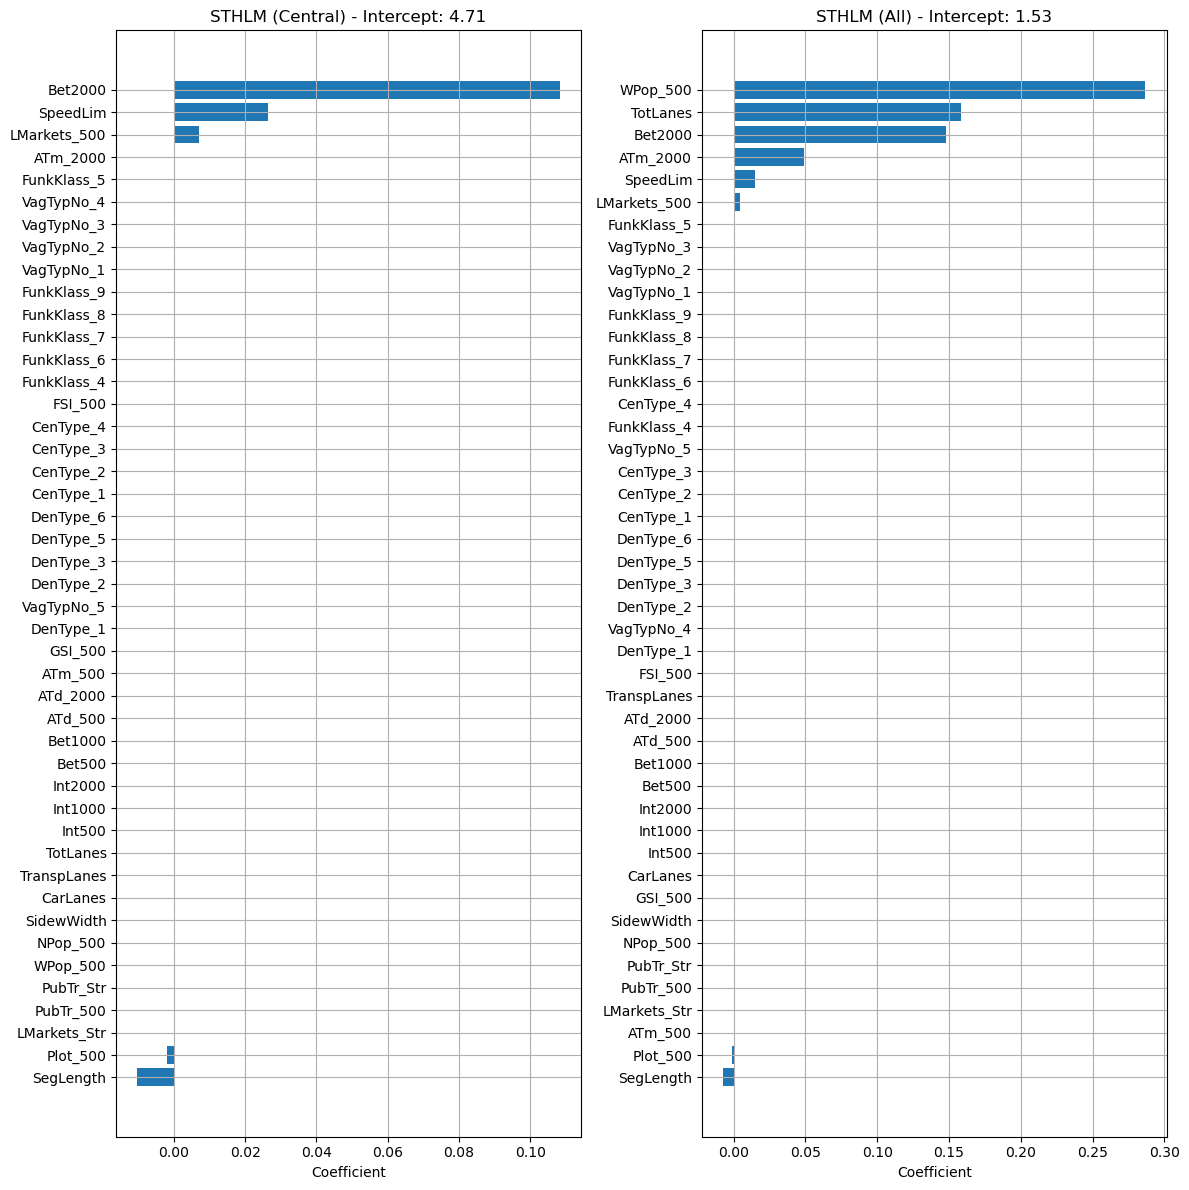

In [11]:
# Plot Coefficients

fix, ax = plt.subplots(1, 2, figsize=(12,12))

f = np.array(feature_names)
idx = np.argsort(central_coefs)[::-1]
x = np.arange(idx.shape[0])

ax[0].barh(x, central_coefs[idx], align='center')
ax[0].set_yticks(x)
ax[0].set_yticklabels(f[idx])
ax[0].invert_yaxis()
ax[0].grid(True)
ax[0].set_title('STHLM (Central) - Intercept: ' + '{:.2f}'.format(central_intercept))
ax[0].set_xlabel('Coefficient')

f = np.array(feature_names)
idx = np.argsort(all_coefs)[::-1]
x = np.arange(idx.shape[0])

ax[1].barh(x, all_coefs[idx], align='center')
ax[1].set_yticks(x)
ax[1].set_yticklabels(f[idx])
ax[1].invert_yaxis()
ax[1].grid(True)
ax[1].set_title('STHLM (All) - Intercept: ' + '{:.2f}'.format(all_intercept))
ax[1].set_xlabel('Coefficient')

plt.tight_layout()
plt.show()
